In [1]:
%matplotlib inline

In [2]:
n1, n2 = int(5e4), int(2e4)
Lbox = 1000.
x1 = np.random.uniform(0, Lbox, n1)
y1 = np.random.uniform(0, Lbox, n1)
z1 = np.random.uniform(0, Lbox, n1)
x2 = np.random.uniform(0, Lbox, n2)
y2 = np.random.uniform(0, Lbox, n2)
z2 = np.random.uniform(0, Lbox, n2)


In [3]:
from chaining_mesh import calculate_chaining_mesh

nx1, ny1, nz1 = 5, 5, 5
lx1, ly1, lz1 = Lbox, Lbox, Lbox
result = calculate_chaining_mesh(x1, y1, z1, lx1, ly1, lz1, nx1, ny1, nz1)
x1, y1, z1, ix1, iy1, iz1, cell_id1, idx_sorted1, cell_id1_indices = result

nx2, ny2, nz2 = 15, 14, 16
lx2, ly2, lz2 = Lbox, Lbox, Lbox
result = calculate_chaining_mesh(x2, y2, z2, lx2, ly2, lz2, nx2, ny2, nz2)
x2, y2, z2, ix2, iy2, iz2, cell_id2, idx_sorted2, cell_id2_indices = result

cell1_size_x = Lbox/nx1
cell1_size_y = Lbox/ny1
cell1_size_z = Lbox/nz1
cell2_size_x = Lbox/nx2
cell2_size_y = Lbox/ny2
cell2_size_z = Lbox/nz2


In [4]:
def low_index_cell2(s1_low, rmax, ds2):
    return max(int((s1_low - rmax)/ds2), 0)

def high_index_cell2(s1_high, rmax, ds2, n2):
    return min(int((s1_high + rmax)/ds2) + 1, n2-1)

def cell2_index_bounds(ix1, iy1, iz1, dx1, dy1, dz1, 
                       rmax_x, rmax_y, rmax_z, 
                       dx2, dy2, dz2, nx2, ny2, nz2):
    x1_low = ix1*dx1
    x1_high = (ix1+1)*dx1
    y1_low = iy1*dy1
    y1_high = (iy1+1)*dy1
    z1_low = iz1*dy1
    z1_high = (iz1+1)*dz1

    ix2_low = low_index_cell2(x1_low, rmax_x, dx2)
    iy2_low = low_index_cell2(y1_low, rmax_y, dy2)
    iz2_low = low_index_cell2(z1_low, rmax_z, dz2)
    ix2_high = high_index_cell2(x1_high, rmax_x, dx2, nx2)
    iy2_high = high_index_cell2(y1_high, rmax_y, dy2, ny2)
    iz2_high = high_index_cell2(z1_high, rmax_z, dz2, nz2)
    
    return ix2_low, ix2_high, iy2_low, iy2_high, iz2_low, iz2_high

def generate_cell2_ids(ix1, iy1, iz1, dx1, dy1, dz1, rmax_x, rmax_y, rmax_z, 
                  dx2, dy2, dz2, nx2, ny2, nz2):
    result = cell2_index_bounds(
        ix1, iy1, iz1, dx1, dy1, dz1, rmax_x, rmax_y, rmax_z, 
        dx2, dy2, dz2, nx2, ny2, nz2)
    ix2_low, ix2_high, iy2_low, iy2_high, iz2_low, iz2_high = result
    for ix2 in range(ix2_low, ix2_high+1):
        assert ix2 < nx2, (ix2, nx2)
        for iy2 in range(iy2_low, iy2_high+1):
            assert iy2 < ny2, (iy2, ny2)
            for iz2 in range(iz2_low, iz2_high+1):
                assert iz2 < nz2, (iz2, nz2)
                try:
                    icell2 = np.ravel_multi_index( (ix2, iy2, iz2), (nx2, ny2, nz2) )
                except ValueError:
                    print((ix2, iy2, iz2), (nx2, ny2, nz2))
                yield icell2

def calculate_sample2_mask(ix1, iy1, iz1, dx1, dy1, dz1, rmax_x, rmax_y, rmax_z, 
                  dx2, dy2, dz2, nx2, ny2, nz2, cell2_ids):
    gen = generate_cell2_ids(ix1, iy1, iz1, dx1, dy1, dz1, rmax_x, rmax_y, rmax_z, 
                  dx2, dy2, dz2, nx2, ny2, nz2)
    mask = np.zeros_like(cell2_ids).astype(bool)
    for icell2 in gen:
        mask |= cell2_ids == icell2
    return mask

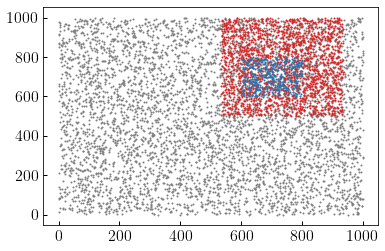

In [5]:
ix1, iy1, iz1 = nx1-2, ny1-2, nz1-2
rmax_x, rmax_y, rmax_z = 40., 60., 100.
args = (ix1, iy1, iz1, cell1_size_x, cell1_size_y, cell1_size_z,
       rmax_x, rmax_y, rmax_z, cell2_size_x, cell2_size_y, cell2_size_z,
       nx2, ny2, nz2, cell_id2)
sample2_mask = calculate_sample2_mask(*args)


fig, ax = plt.subplots(1, 1)

__=ax.scatter(x1[::10], y1[::10], s=1, color='gray')

x1_lo = ix1*cell1_size_x
y1_lo = iy1*cell1_size_y
z1_lo = iz1*cell1_size_z
x1_hi = (ix1+1)*cell1_size_x
y1_hi = (iy1+1)*cell1_size_y
z1_hi = (iz1+1)*cell1_size_z

mask1 = (x1 >= x1_lo) & (x1 <= x1_hi)
mask1 &= (y1 >= y1_lo) & (y1 <= y1_hi)
mask1 &= (z1 >= z1_lo) & (z1 <= z1_hi)
x1_plot = x1[mask1]
y1_plot = y1[mask1]
z1_plot = z1[mask1]

x2_plot = x2[sample2_mask]
y2_plot = y2[sample2_mask]
z2_plot = z2[sample2_mask]
__=ax.scatter(x2_plot, y2_plot, s=1, color=mred)
__=ax.scatter(x1_plot, y1_plot, s=1, color=mblue)
